# Завдання

_Вправа 1: натренуйте модель дерева рішень та виконайте пошук гіперпараметрів для moons dataset._ \
a. Згенеруйте датасет, використовуючи функцію `make_moons(n_samples=10000, noise=0.4)`. \
b. Розбийте її на тренувальну та тестувальну частини, використовуючи функцію `train_test_split()`. \
c. Використайте пошук з крос-валідацією (`GridSearchCV`, `RandomizedSearchCV`) для пошуку гіперпараметрів моделі `DecisionTreeClassifier`. Зокрема, спробуйте різні значення для параметра `max_leaf_nodes`.

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import uniform, randint

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
np.random.seed(42)

In [3]:
X, y = make_moons(n_samples=10000, noise=0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [4]:
grid_search_params = {
    'max_depth': np.arange(1, 21, 2),
    'max_leaf_nodes': np.arange(2, 21, 2),
    'min_samples_leaf': np.arange(1, 21, 2),
    'min_samples_split': np.arange(2, 21, 2),
}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              param_grid=grid_search_params,
                              cv=3,
                              n_jobs=-1,
                              scoring='accuracy')
grid_search_cv.fit(X_train, y_train)

best_grid_search_tree = grid_search_cv.best_estimator_
best_grid_search_tree

,criterion,'gini'
,splitter,'best'
,max_depth,np.int64(7)
,min_samples_split,np.int64(2)
,min_samples_leaf,np.int64(1)
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,np.int64(18)
,min_impurity_decrease,0.0
,class_weight,None


In [5]:
def plot_params(cv_results, best_params, best_score):
    results = pd.DataFrame(cv_results)
    parameters = ['max_depth', 'max_leaf_nodes', 'min_samples_leaf', 'min_samples_split']

    plt.figure(figsize=(10, 8))
    plt.suptitle('peak accuracy per parameter')

    for i, param in enumerate(parameters, 1):
        plt.subplot(2, 2, i)

        peak_scores = results.groupby(f'param_{param}')['mean_test_score'].max()

        plt.plot(peak_scores.index.astype(int), peak_scores.values, marker='o', label='peak per value')

        best_param_value = best_params[param.replace('param_', '')]
        plt.plot(best_param_value, best_score, 'o', label='best overall')

        plt.xlabel(f'{param.replace('param_', '')} value')
        plt.ylabel('accuracy')
        plt.title(f'{param.replace('param_', '')} peak impact')
        plt.grid(True)
        plt.legend()

    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()


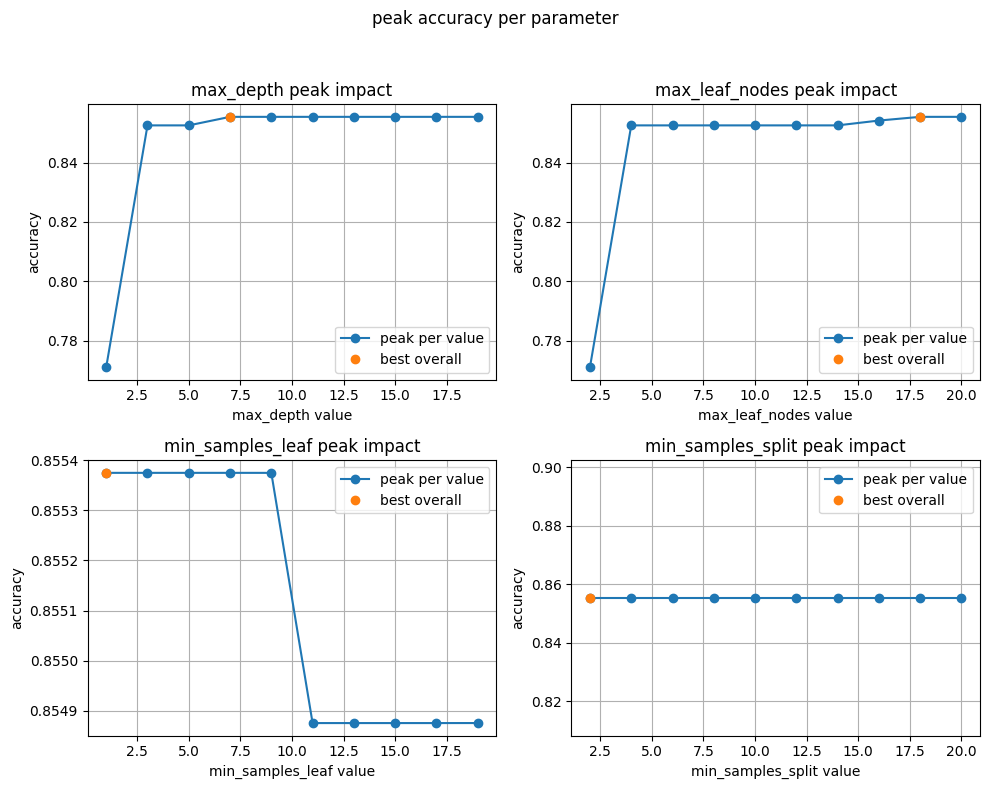

In [6]:
plot_params(grid_search_cv.cv_results_, grid_search_cv.best_params_, grid_search_cv.best_score_)

In [7]:
grid_search_cv.best_params_

{'max_depth': np.int64(7),
 'max_leaf_nodes': np.int64(18),
 'min_samples_leaf': np.int64(1),
 'min_samples_split': np.int64(2)}

In [8]:
grid_search_cv.best_score_

np.float64(0.855375167376396)

In [9]:
best_grid_search_tree.score(X_test, y_test)

0.8695

In [10]:
y_pred = best_grid_search_tree.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1013
           1       0.88      0.86      0.87       987

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

[[893 120]
 [141 846]]


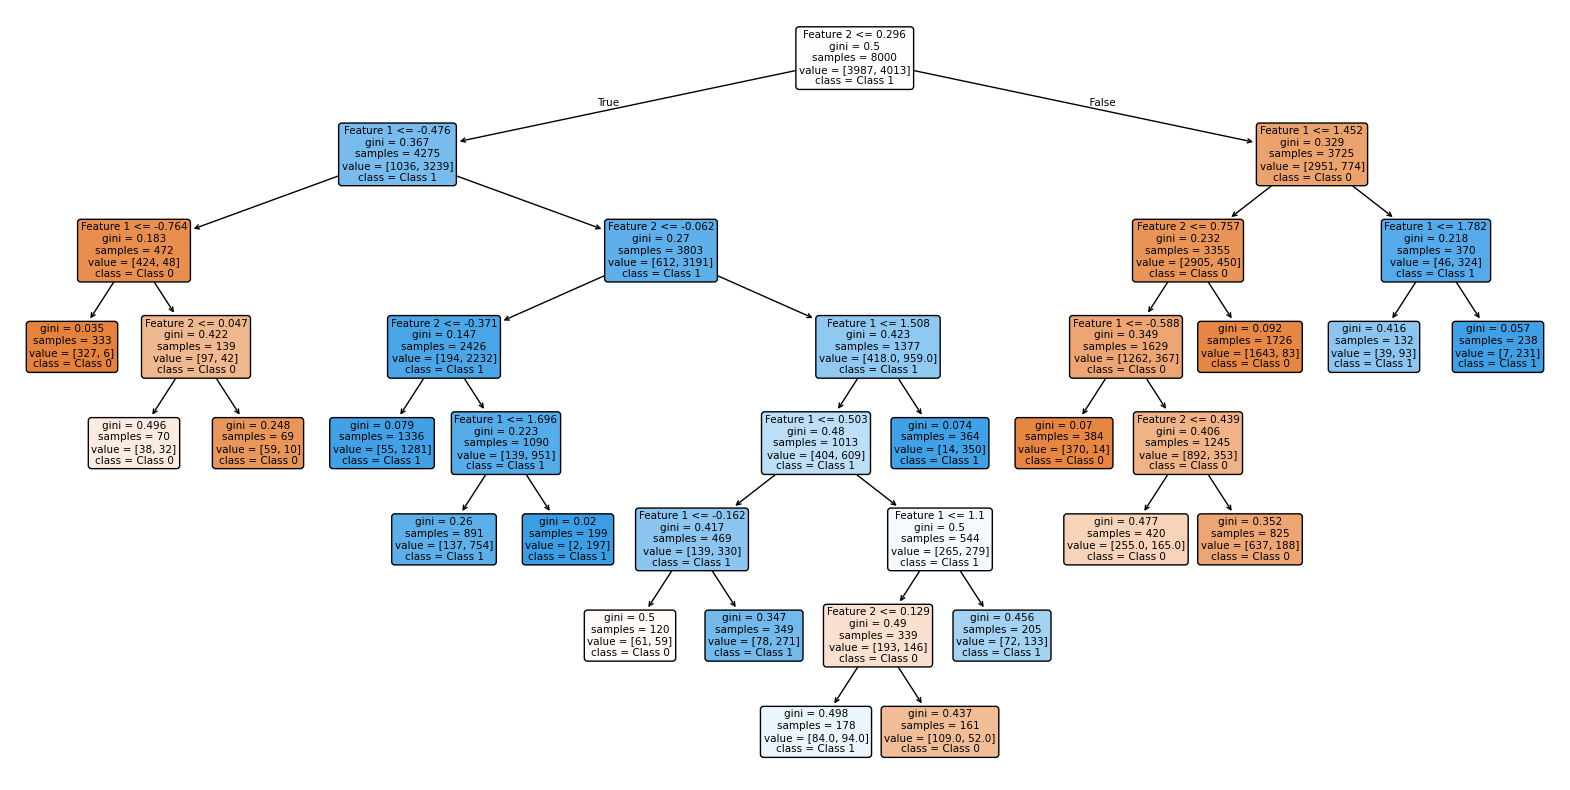

In [11]:
plt.figure(figsize=(20, 10))
plot_tree(best_grid_search_tree, feature_names=["Feature 1", "Feature 2"], class_names=["Class 0", "Class 1"],
          filled=True,
          rounded=True)
plt.show()

In [12]:
random_search_params = {
    'max_depth': randint(1, 21),
    'max_leaf_nodes': randint(2, 31),
    'min_samples_leaf': randint(1, 21),
    'min_samples_split': randint(2, 21),
}

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=random_search_params,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    n_iter=150,
    random_state=42)

random_search.fit(X_train, y_train)

best_random_search_tree = random_search.best_estimator_
random_search.best_estimator_

,criterion,'gini'
,splitter,'best'
,max_depth,7
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,28
,min_impurity_decrease,0.0
,class_weight,None


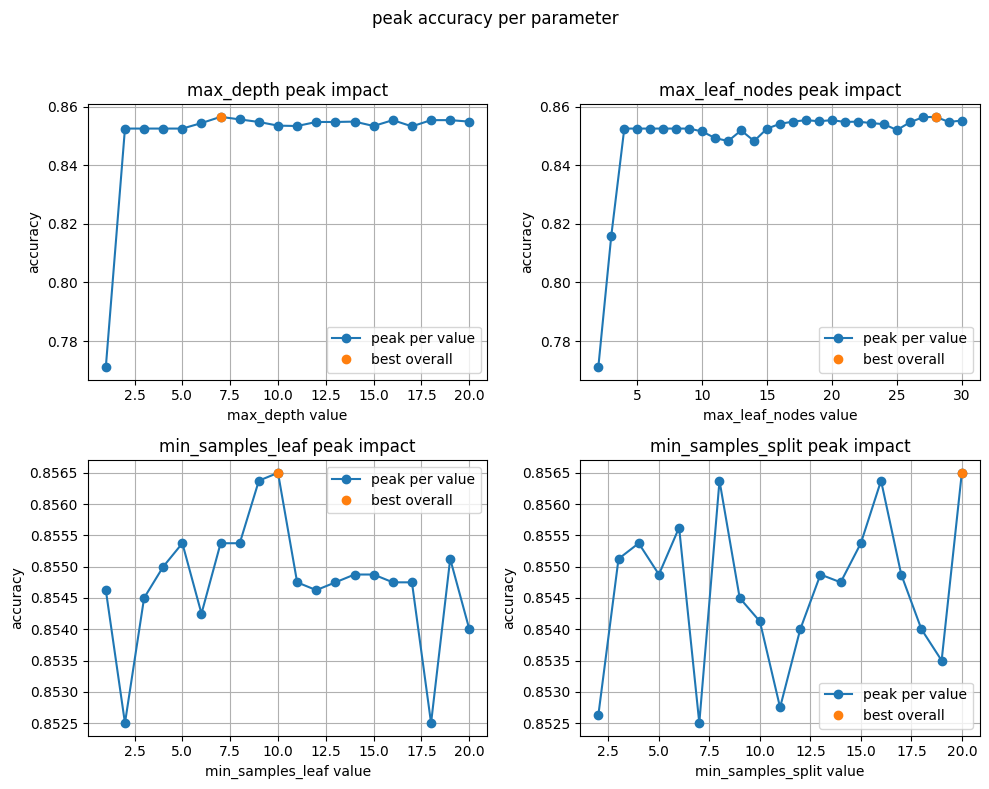

In [13]:
plot_params(random_search.cv_results_, random_search.best_params_, random_search.best_score_)

In [14]:
random_search.best_params_

{'max_depth': 7,
 'max_leaf_nodes': 28,
 'min_samples_leaf': 10,
 'min_samples_split': 20}

In [15]:
random_search.best_score_

np.float64(0.8565002611732798)

In [16]:
best_random_search_tree.score(X_test, y_test)

0.8715

In [17]:
y_pred = best_random_search_tree.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1013
           1       0.86      0.89      0.87       987

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

[[867 146]
 [111 876]]


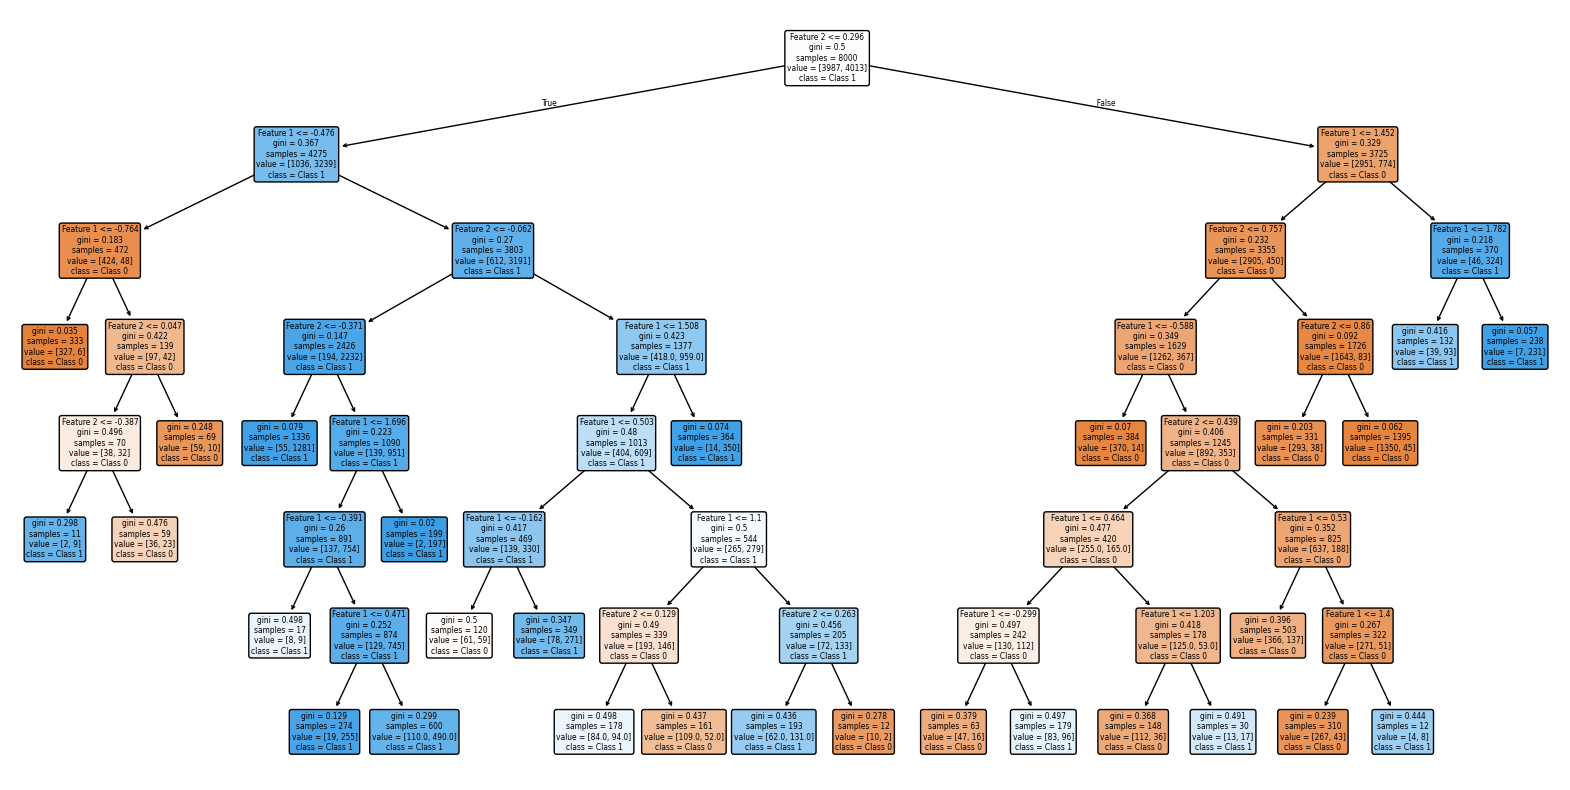

In [18]:
plt.figure(figsize=(20, 10))
plot_tree(random_search.best_estimator_, feature_names=["Feature 1", "Feature 2"], class_names=["Class 0", "Class 1"],
          filled=True,
          rounded=True)
plt.show()

In summary, both GridSearchCV and RandomSearchCV selected max_depth = 7. For max_leaf_nodes, both selected the best value on this conditional plateau, as shown in the graph. Other parameters are different. Interestingly, GridSearch selected the default values for min_samples_leaf and min_samples_split and in RandomSearchCV they are just random values with best performance.

_Вправа 2_ : \
a. Завантажте датасет MNIST та розбийте його на тренувальну, валідаційну та тестувальну частини (наприклад, 50 000 / 10 000 / 10
000). \
b. Натренуйте різні класифікаційні моделі (Random Forest classifier, Logistic Regression, SVM). \
c. Далі, об'єднайте їх за допомогою голосування. \
d. Натренуйте нову модель, використовуючи виходи попередніх моделей на валідаційній вибірці (це будуть нові ознаки і нова тренувальна вибірка для даної моделі). Протестуйте отриманий ланцюжок на тренувальний вибірці. Такий спосіб поєднання моделей називається стогуванням (stacking).  

In [19]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:50000]
y_train = y[:50000]
X_test = X[60000:]
y_test = y[60000:]

X_val = X[50000:60000]
y_val = y[50000:60000]

In [20]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [21]:
mnist.data.shape

(70000, 784)

In [22]:
mnist.target.shape

(70000,)

In [23]:
random_forest_classifier = make_pipeline(
    RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
    ),
)
random_forest_classifier.fit(X_train, y_train)

,steps,"[('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'


In [24]:
logistic_regression = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=1000),
)
logistic_regression.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [25]:
svm_classifier = make_pipeline(
    StandardScaler(),
    SVC(random_state=42),
)
svm_classifier.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [26]:
y_pred_rfc = random_forest_classifier.predict(X_test)
y_pred_lr = logistic_regression.predict(X_test)
y_pred_svc = svm_classifier.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred_rfc))
print(confusion_matrix(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.96      1028
           8       0.96      0.95      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

[[ 969    1    0    0    0    4    3    1    1    1]
 [   0 1121    3    3    0    2    2    0    3    1]
 [   5    0 1000    3    4    0    3   11    6    0]
 [   0    0   11  973    0    7    0    9    8    2]
 [   1    0    2    0  952   

In [28]:
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.92      0.89      0.91      1032
           3       0.90      0.92      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.89      0.87      0.88       892
           6       0.94      0.94      0.94       958
           7       0.93      0.92      0.92      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

[[ 945    0    3    4    3   10    9    2    4    0]
 [   0 1108    7    3    0    2    3    2   10    0]
 [   9   13  918   16    9    6   13    9   36    3]
 [   3    1   16  925    2   20    3   11   19   10]
 [   3    4    9    4  914   

In [29]:
print(classification_report(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.96      0.95      0.96       892
           6       0.98      0.97      0.97       958
           7       0.92      0.96      0.94      1028
           8       0.96      0.95      0.95       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 966    0    1    2    0    3    4    3    1    0]
 [   0 1126    3    0    0    1    3    0    2    0]
 [   5    1  996    2    2    0    1   15    9    1]
 [   0    0    6  976    0    7    0   13    8    0]
 [   0    0   12    0  943   

### Voting

In [30]:
voting_classifier = VotingClassifier(
    estimators=[('random_forest', random_forest_classifier), ('logistic_regression', logistic_regression),
                ('svc', svm_classifier)],
    voting='hard',
    n_jobs=-1,
)
voting_classifier.fit(X_train, y_train)

,estimators,"[('random_forest', ...), ('logistic_regression', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [31]:
y_pred_vc = voting_classifier.predict(X_test)
print(classification_report(y_test, y_pred_vc))
print(confusion_matrix(y_test, y_pred_vc))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.97      0.98       958
           7       0.97      0.95      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

[[ 971    0    1    1    0    3    2    1    1    0]
 [   0 1124    3    2    0    1    2    0    3    0]
 [   6    3  997    3    3    0    2    8    9    1]
 [   0    0   10  979    0    5    0    9    7    0]
 [   1    0   11    0  950   

### Stacking

In [36]:
y_pred_rfc_on_val = random_forest_classifier.predict(X_val)
y_pred_lr_on_val = logistic_regression.predict(X_val)
y_pred_svc_on_val = svm_classifier.predict(X_val)

X_train_stacking = np.column_stack([y_pred_rfc_on_val, y_pred_lr_on_val, y_pred_svc_on_val])
y_train_stacking = y_val

stacking_classifier = LogisticRegression(random_state=42, max_iter=1000)
stacking_classifier.fit(X_train_stacking, y_train_stacking)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [37]:
y_pred_rfc_test = random_forest_classifier.predict(X_test)
y_pred_lr_test = logistic_regression.predict(X_test)
y_pred_svc_test = svm_classifier.predict(X_test)

In [38]:
X_test_classifier = np.column_stack([y_pred_rfc_test, y_pred_lr_test, y_pred_svc_test])
y_pred_stacking = stacking_classifier.predict(X_test_classifier)

In [39]:
print(classification_report(y_test, y_pred_stacking))
print(confusion_matrix(y_test, y_pred_stacking))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.95      0.95      1010
           4       0.92      0.95      0.93       982
           5       0.93      0.93      0.93       892
           6       0.91      0.96      0.93       958
           7       0.94      0.93      0.94      1028
           8       0.95      0.93      0.94       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

[[ 964    0    3    5    2    2    2    1    1    0]
 [   0 1112   12    2    2    4    2    0    1    0]
 [   5    0  986    7   12    6    8    2    5    1]
 [   0    0   10  956   12   12   10    7    3    0]
 [   1    0    2    8  935   

Voting Classifier proved to be better than Stacking. However, it should be noted that RandomForestClassifier performs well on its own, along with SVC, although it takes a long time to train such a large dataset.